In [1]:
# Import tensorflow and other required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import glob
import imageio
import os
import PIL
import time
import tensorflow as tf
from IPython import display

In [5]:
(train_images, train_labels), (_,_) =  tf.keras.datasets.fashion_mnist.load_data()

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 300 # Batch size is the number of samples processed before the model is up dated

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [11]:
# Define the Generator Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, Activation, BatchNormalization,LeakyReLU,Conv2DTranspose, Reshape

In [17]:
def generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100, )))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Reshape((7, 7, 256)))
    #assert model.output_shape == (None, 7, 7, 256) #Note: None is the batch size
    model.add(Conv2DTranspose(128, (5,5), strides = (1,1), padding='same', use_bias=False))
    
    # 128 is the dimensionality of the output space
    # (5,5) specifies the height and width of the 2D convolution window
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    #assert model.ouput_shape == (None, 28, 28, 1)
    
    return model

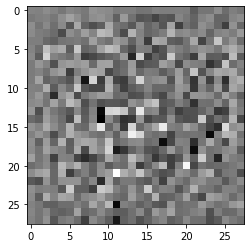

In [18]:
# Let's use the Untrained Generator to create an Image

generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [19]:
# Define the Discriminator i.e. a CNN-based Image Classifier

def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5,5), strides = (2,2), padding="same", input_shape=[28,28,1]))
    
    model.add(LeakyReLU())
    model.add(Dropout(0.3)) # to deactivate 30% neurons randomly to prevent overfitting
    
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3)) # to deactivate 30% neurons randomly to prevent overfitting
    
    model.add(Flatten()) # Converts multi dimensional array to 1D channel
    model.add(Dense(1))
    
    return model

In [20]:
# Use the Untrained Discriminator to classify the generated images as real or fake
# The model will be trained to output positive values for real images, and negative values for fake images

discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00140799]], shape=(1, 1), dtype=float32)


In [21]:
# Define loss functions and optimizers for both models

from tensorflow.keras.losses import BinaryCrossentropy
# This method returns a helper function to compute cross entropy loss
cross_entropy = BinaryCrossentropy(from_logits=True)

In [22]:
# Discriminator Loss
# This method helps to distinguish between real images from fake by discriminator
# Compares teh discriminator;s predictions on real images to an array of 0s 
# and the discriminator;s predictions on fake (generated) images to an array of 0s

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
# The generator's loss quantifies how well it was able to fool the discriminator 
# If the generator is performing well, the discriminator will classify the fake images as real (or 1)
# Here, we will compare the discriminators decisions on the generated images to an array of 1s

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
# The Discriminator and the Generator Optimizers are different because we are training two network separately
from tensorflow.keras.optimizers import Adam

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [30]:
# Define the training loop

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime
seed = tf.random.normal([num_examples_to_generate, nosie_dim])

In [31]:
# Train the model

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled"

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [32]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
    
        for image_batch in dataset:
            train_step(image_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)

In [35]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False
    # This is so all layers run in inference mode (batchnorm)
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

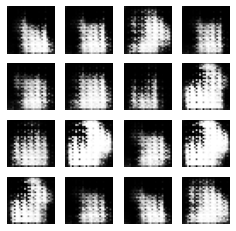

In [36]:
# Here, we are calling the train() method defined above to train the generator and discriminator simultaneously
train(train_dataset, 3) # Training the Model

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(8,8))
img=mpimg.imread('/content/image_at_epoch_0003.png')
imgplot = plt.imshow(img)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/image_at_epoch_0003.png'

<Figure size 576x576 with 0 Axes>